# NN pixelwise confidences: different inference modes, save and load.

NNs performing image segmentation produce results in form of some confidences for each image pixel and for each class. After that, `argmax` is usually applied to mark each pixel with single class.

Now, raw NN confidences may be obtained and stored in Supervisely. The notebook gives an example how to get the confidences from model output and how to work with them.

<span style="color:blue">**NOTE:**</span> the confidences are really heavy. Single annotation with confidences for medium-size image may take up tens of megabytes.

Be patient if you are going to process large amounts of data. Consider following approaches:
* Don't store unused classes.
* Don't work with unused data, consider image cropping and inference with ROI mode.
* Remove unused data/projects periodically.
* Don't store confidences at all, process model output on-the-fly.
* Run inference on appropriately scaled images. If image is significantly larger than NN head then output confidence maps will be enlarged to original image size and take excess place without providing any additional information. E.g., for full image 1024x768 and NN head 256x256, stored data will take up twelve times as original NN output.


## Beginning

### Imports

In [1]:
# PyPlot for drawing images in Jupyter.
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import scipy

import supervisely_lib as sly

### Initialize API access with your credentials

In [2]:
api = sly.Api.from_env()

### Script parameters

In [3]:
TEAM_NAME = 'admin'
WORKSPACE_NAME = 'nn_probs_3'

AGENT_NAME = 'max_server'
GPU_ID = 0

MODEL_NAME = 'DeepLab v3 plus (VOC2012)'

DST_PROJECT_NAME = "pixelwise_save_test"

### Get access to workspace/team/agent

In [4]:
team = api.team.get_info_by_name(TEAM_NAME)
if team is None:
    raise RuntimeError("Team {!r} not found".format(TEAM_NAME))

workspace = api.workspace.get_info_by_name(team.id, WORKSPACE_NAME)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(WORKSPACE_NAME))

print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))

agent = api.agent.get_info_by_name(team.id, AGENT_NAME)
if agent is None:
    raise RuntimeError("Agent {!r} not found".format(AGENT_NAME))
    
if agent.status is api.agent.Status.WAITING:
    raise RuntimeError("Agent {!r} is not running".format(AGENT_NAME))
print("Agent: id={}, name={}".format(agent.id, agent.name))

Team: id=1, name=admin
Workspace: id=8, name=nn_probs_3
Agent: id=3, name=max_server


### Deploy model for segmentation.

We will use DeepLab pretrained on Pascal VOC.

Find existing model or add it from provided Model Zoo:

In [5]:
model = api.model.get_info_by_name(workspace.id, MODEL_NAME)
if model is None:
    print('Will clone from Model Zoo...')
    clone_task_id = api.model.clone_from_explore("Supervisely/Model Zoo/" + MODEL_NAME,
                                                 workspace.id,
                                                 MODEL_NAME)
    api.task.wait(clone_task_id, api.task.Status.FINISHED)
    model = api.model.get_info_by_name(workspace.id, MODEL_NAME)

print("Model: id={}, name={}".format(model.id, model.name))

model = api.model.get_info_by_name(workspace.id, MODEL_NAME)
print('Model: id = {}, name = {!r}'.format(model.id, model.name))

Model: id=35, name=DeepLab v3 plus (VOC2012)
Model: id = 35, name = 'DeepLab v3 plus (VOC2012)'


Deploy model with agent:

In [6]:
def api_deploy_model(agent_id, model_id, gpu_id):
    task_id = api.task._deploy_model(agent_id, model_id, settings={'gpu_device': gpu_id})
    return task_id

task_ids = api.model.get_deploy_tasks(model.id)
if len(task_ids) == 0:
    print('Model {!r} is not deployed. Deploying...'.format(model.name))
    task_id = api_deploy_model(agent.id, model.id, GPU_ID)
    api.task.wait(task_id, api.task.Status.DEPLOYED)
else:
    print('Model {!r} has already been deployed.'.format(model.name))
    task_id = task_ids[0]
print('Deploy task_id = {}'.format(task_id))

Model 'DeepLab v3 plus (VOC2012)' has already been deployed.
Deploy task_id = 44


## Get all pixelwise scores for some image

### Prepare inference config

To get NN pixelwise scores just pass `"save_probabilities": True` through inference mode config.

In [7]:
full_image_mode_config = {
    "model_classes": {
      "save_classes": "__all__",
      "add_suffix": "_dl"
    },
    "save_probabilities": True
}

CURR_PROJECT_ID = 26
CURR_IMAGE_ID = 435

Our model knows 21 classes (including `bg` -- background).

In [8]:
meta_json = api.model.get_output_meta(model.id, inference_mode=full_image_mode_config)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+-----------------+--------+-----------------+
|       Name      | Shape  |      Color      |
+-----------------+--------+-----------------+
|      bg_dl      | Bitmap | [182, 182, 159] |
|   aeroplane_dl  | Bitmap |  [255, 0, 153]  |
|    bicycle_dl   | Bitmap |  [191, 0, 115]  |
|     bird_dl     | Bitmap |   [128, 0, 77]  |
|     boat_dl     | Bitmap |  [179, 0, 255]  |
|    bottle_dl    | Bitmap |  [134, 0, 191]  |
|      bus_dl     | Bitmap |   [90, 0, 128]  |
|      car_dl     | Bitmap |   [9, 0, 255]   |
|      cat_dl     | Bitmap |   [6, 0, 191]   |
|     chair_dl    | Bitmap |   [4, 0, 128]   |
|      cow_dl     | Bitmap |  [0, 161, 255]  |
|  diningtable_dl | Bitmap |  [0, 121, 191]  |
|      dog_dl     | Bitmap |   [0, 81, 128]  |
|     horse_dl    | Bitmap |  [0, 255, 179]  |
|   motorbike_dl  | Bitmap |  [0, 191, 134]  |
|    person_dl    | Bitmap |   [0, 128, 90]  |
| potted-plant_dl | Bitmap |   [0, 255, 0]   |
|     sheep_dl    | Bitmap |   [

### Take some image...

In [9]:
def draw_image(img, figsize=(8, 8)):
    print("Draw {}x{}:".format(img.shape[0], img.shape[1]))
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show() 

Draw 960x640:


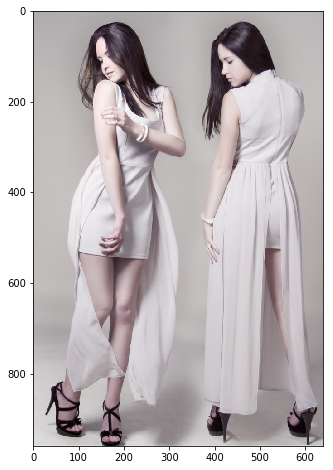

In [10]:
img = api.image.download_np(CURR_IMAGE_ID)
draw_image(img)

### ... and run inference with the determined config

It may be slow to transmit inference results from agent to you.

In [11]:
ann_json = api.model.inference(model.id, img, mode=full_image_mode_config)
print("Inference processed.")

Inference processed.


<span style="color:blue">**NOTE:**</span> Remember that now the annotation is **NOT** lightweight.

In [13]:
print('Bytes: {:,}'.format(len(str(ann_json))))

Bytes: 62,944,811


Pack / unpack annotation as usual. Pixelwise scores are stored in `pixelwise_scores_labels` field.

In [14]:
ann = sly.Annotation.from_json(ann_json, model_meta)

### Explore results

Draw usual (binary) labels:

In [17]:
def draw_image_with_labels(img, ann, figsize=(8, 8)):
    img = img.copy()
    for lbl in ann.labels:
        lbl.draw_contour(img, thickness=3)
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show() 

One can see contours for binary bitmaps. Note the wrong segmentation result in lower-right corner: background shadow is marked as a "chair".

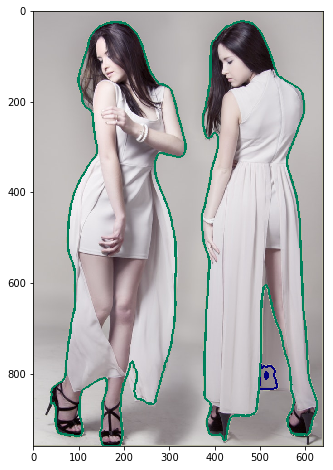

In [19]:
draw_image_with_labels(img, ann)

Now draw obtained confidences.

They are stored in `pixelwise_scores_labels` field and they are in the form of `MultichannelBitmap` geometry. In fact, each label contains single-channel array of floats. One may consider it as usual labels of other types.

In [20]:
def print_lbl_data(lbl):
    data = lbl.geometry.data
    print("Class {} | shape {} | type {} | min={} | max={} | mean={} | std={}".format(
        lbl.obj_class.name, data.shape, data.dtype, 
        np.min(data), np.max(data), np.mean(data), np.std(data)
    ))    

In [25]:
# the plot normalization doesn't affect image data
def draw_confidences(data, figsize=(8, 8), norm=plt.Normalize(0, 1)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.squeeze(data), cmap='gray', norm=norm)
    plt.show() 

Now we can see the confidences for some classes. White means 1, black means 0, and shadows of grey mean something between.

There are pixel-wise NN answers about background, aeroplane (not found), chair (maybe in corner?), and person (here they are).

Class bg_dl | shape (960, 640, 1) | type float32 | min=4.270303008979681e-07 | max=1.0 | mean=0.46353214979171753 | std=0.48002102971076965


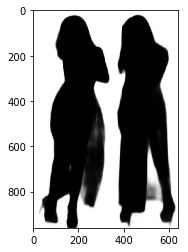

Class aeroplane_dl | shape (960, 640, 1) | type float32 | min=1.0196023886299699e-10 | max=0.00013550263247452676 | mean=8.506640369887464e-07 | std=2.485456661815988e-06


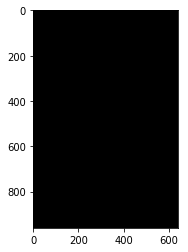

Class chair_dl | shape (960, 640, 1) | type float32 | min=3.3608221761127766e-10 | max=0.7058790922164917 | mean=0.0034970715641975403 | std=0.03595638647675514


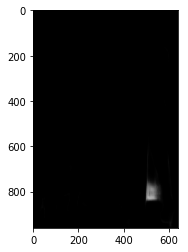

Class person_dl | shape (960, 640, 1) | type float32 | min=2.4115193175688887e-10 | max=0.9999994039535522 | mean=0.5328443050384521 | std=0.48178568482398987


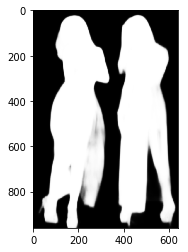

In [23]:
for lbl in ann.pixelwise_scores_labels:
    if lbl.obj_class.name not in ('bg_dl', 'aeroplane_dl', 'chair_dl', 'person_dl'):
        continue  # will not draw black images
    print_lbl_data(lbl)
    draw_confidences(lbl.geometry.data, figsize=(4, 4))

<span style="color:blue">**NOTE:**</span> sense and range of the NN confidences depend on which NN model you are going to use. E.g., the confidences may be represented as probabilities from [0; 1] or as [logits](https://en.wikipedia.org/wiki/Logit) from  (−∞, +∞).

In this example each object stores floats from range \[0; 1\] due to DeepLab output (logits are pass through softmax).

Let's check that nothing is lost. For each pixel the sum of probabilities by classes should be equal 1. Don't forget to consider all classes from model output, not only interesting ones.

In [26]:
# manual stack & check
all_channels = np.stack([np.squeeze(lbl.geometry.data) for lbl in ann.pixelwise_scores_labels], axis=2)
print(all_channels.shape)

(960, 640, 21)


In [27]:
prob_sum = np.sum(all_channels, axis=2)
all_ones = np.ones_like(prob_sum)
assert(np.allclose(prob_sum, all_ones))  # check sum == 1
print('Sum is correct.')

Sum is correct.


## Different inference modes

Here we save only "person" class.

### Full image

In [28]:
mode_config = {
    "model_classes": {
      "save_classes": ["person"],
      "add_suffix": "_dl"
    },
    "save_probabilities": True
}

CURR_PROJECT_ID = 26
CURR_IMAGE_ID = 437

In [29]:
meta_json = api.model.get_output_meta(model.id, inference_mode=mode_config)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+-----------+--------+--------------+
|    Name   | Shape  |    Color     |
+-----------+--------+--------------+
| person_dl | Bitmap | [0, 128, 90] |
+-----------+--------+--------------+
Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [30]:
img = api.image.download_np(CURR_IMAGE_ID)

In [31]:
ann_json = api.model.inference(model.id, img, mode=mode_config)

In [32]:
ann = sly.Annotation.from_json(ann_json, model_meta)

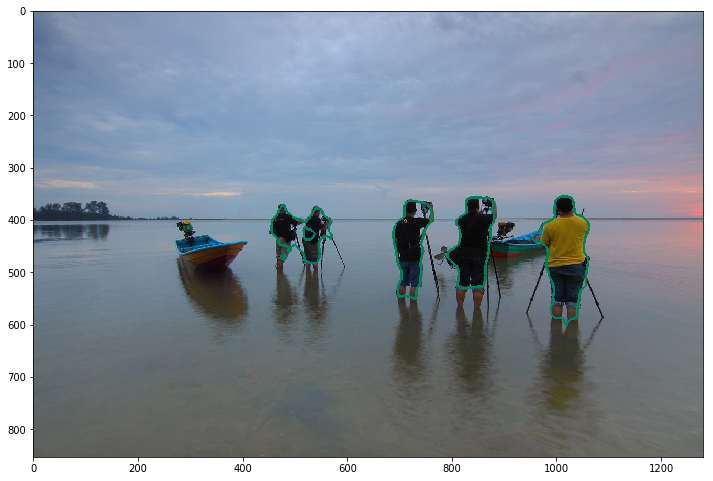

In [33]:
draw_image_with_labels(img, ann, figsize=(12, 12))

Class person_dl | shape (853, 1280, 1) | type float32 | min=1.566403950992168e-10 | max=0.9994800686836243 | mean=0.037109967321157455 | std=0.17431659996509552


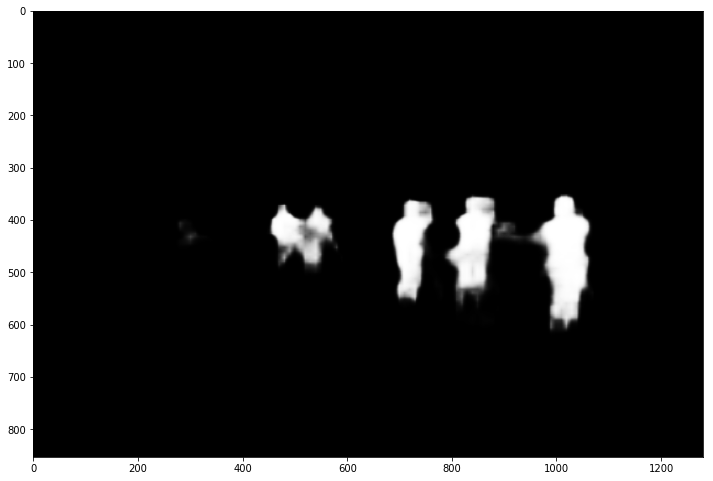

In [34]:
for lbl in ann.pixelwise_scores_labels:
    print_lbl_data(lbl)
    draw_confidences(lbl.geometry.data, figsize=(12, 12))

### ROI (Region Of Interest)

In [35]:
mode_config = {
    "name": "roi",
    "bounds": {
        "left": "50%",
        "top": "20%",
        "right": "20%",
        "bottom": "5%"
    },
    "save": True,
    "class_name": "inference_roi",
    "model_classes": {
        "save_classes": ["person"],
        "add_suffix": "_dl"
    },
    "save_probabilities": True
}

CURR_PROJECT_ID = 26
CURR_IMAGE_ID = 438

In [36]:
img = api.image.download_np(CURR_IMAGE_ID)

In [37]:
meta_json = api.model.get_output_meta(model.id, inference_mode=mode_config)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+---------------+-----------+---------------+
|      Name     |   Shape   |     Color     |
+---------------+-----------+---------------+
|   person_dl   |   Bitmap  |  [0, 128, 90] |
| inference_roi | Rectangle | [83, 138, 15] |
+---------------+-----------+---------------+
Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [38]:
ann_json = api.model.inference(model.id, img, mode=mode_config)

In [39]:
ann = sly.Annotation.from_json(ann_json, model_meta)

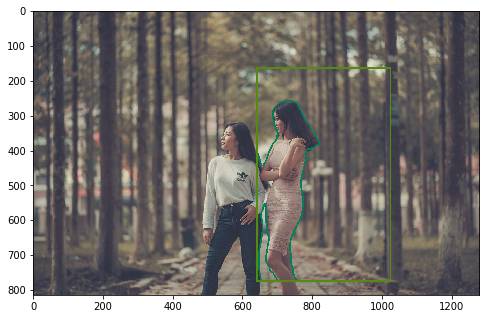

In [40]:
draw_image_with_labels(img, ann)

Class person_dl | shape (612, 384, 1) | type float32 | min=1.8464682005614463e-09 | max=0.999997615814209 | mean=0.22613999247550964 | std=0.4084211587905884


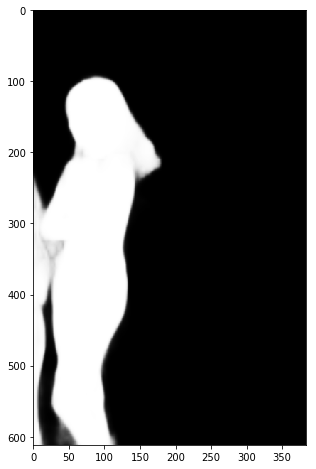

In [41]:
for lbl in ann.pixelwise_scores_labels:
    print_lbl_data(lbl)
    draw_confidences(lbl.geometry.data)

### Bounding Boxes

In [42]:
mode_config = {
    "name": "bboxes",
    "from_classes": "__all__",
    "padding": {
        "left": "5%",
        "top": "5%",
        "right": "5%",
        "bottom": "5%"
    },
    "save": True,
    "add_suffix": "_input_bbox",
    "model_classes": {
        "save_classes": ["person"],
        "add_suffix": "_dl"
    },
    "save_probabilities": True    
}

CURR_PROJECT_ID = 26
CURR_IMAGE_ID = 439

Three annotated bounding boxes are loaded from existing sample project.

In [43]:
img = api.image.download_np(CURR_IMAGE_ID)

src_project_meta_json = api.project.get_meta(CURR_PROJECT_ID)
src_project_meta = sly.ProjectMeta.from_json(src_project_meta_json)

src_ann_info = api.annotation.download(CURR_IMAGE_ID)
src_ann_info_json = src_ann_info.annotation

# unused, just to check if all works
src_ann = sly.Annotation.from_json(src_ann_info_json, src_project_meta)

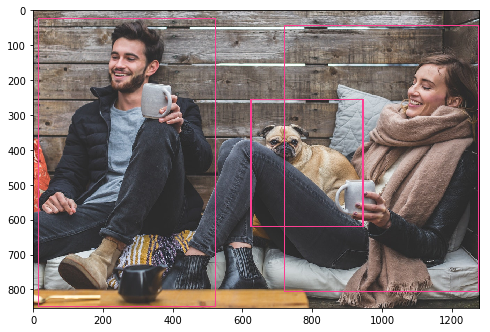

In [44]:
draw_image_with_labels(img, src_ann)

In [45]:
meta_json = api.model.get_output_meta(model.id, input_meta=src_project_meta_json, inference_mode=mode_config)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+-----------------------------+-----------+----------------+
|             Name            |   Shape   |     Color      |
+-----------------------------+-----------+----------------+
|       some_interesting      | Rectangle | [253, 63, 145] |
|          person_dl          |   Bitmap  |  [0, 128, 90]  |
| some_interesting_input_bbox | Rectangle | [253, 63, 145] |
+-----------------------------+-----------+----------------+
Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [46]:
ann_json = api.model.inference(model.id, img, ann=src_ann_info_json, meta=src_project_meta_json, mode=mode_config)

In [47]:
ann = sly.Annotation.from_json(ann_json, model_meta)

Real inference bboxes have 5% of padding from source bboxes (look at config).

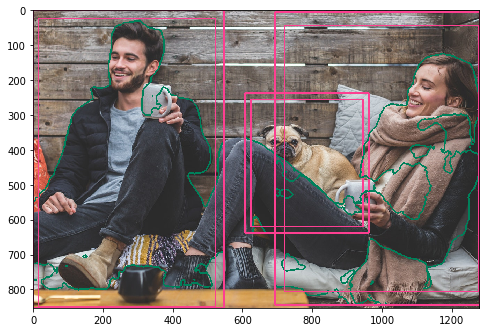

In [48]:
draw_image_with_labels(img, ann)

Class person_dl | shape (853, 548, 1) | type float32 | min=1.3800852016743193e-08 | max=0.9999998807907104 | mean=0.567906379699707 | std=0.46022680401802063


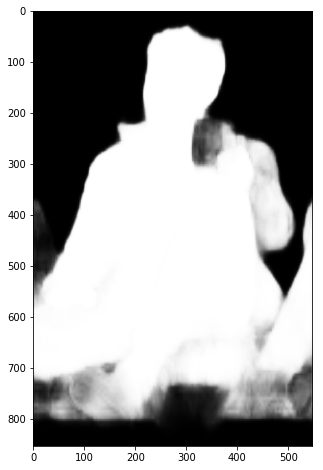

Class person_dl | shape (400, 355, 1) | type float32 | min=1.439810972669875e-07 | max=0.9999208450317383 | mean=0.37146663665771484 | std=0.4514405429363251


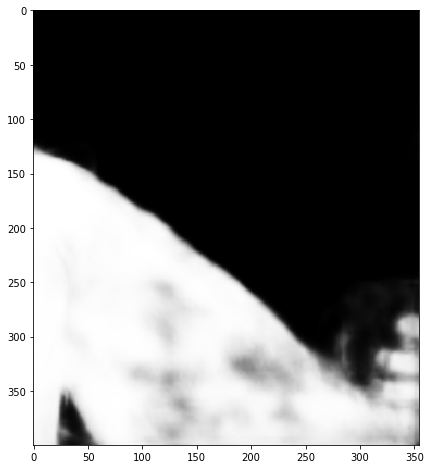

Class person_dl | shape (838, 587, 1) | type float32 | min=1.6271391345412667e-08 | max=0.9999763369560242 | mean=0.3828498125076294 | std=0.4195549488067627


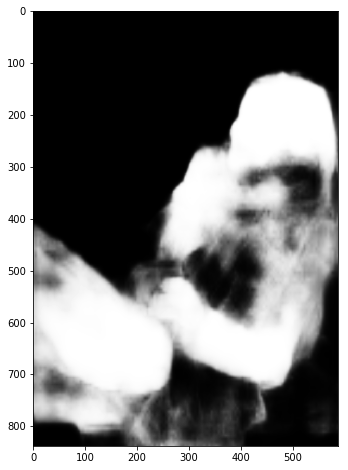

In [49]:
for lbl in ann.pixelwise_scores_labels:
    print_lbl_data(lbl)
    draw_confidences(lbl.geometry.data)

### Sliding Window

In [50]:
mode_config = {
    "name": "sliding_window",
    "window": {
        "width": 300,
        "height": 300
    },
    "min_overlap": {
        "x": 30,
        "y": 30
    },
    "save": True,
    "class_name": "sl_window",
    "model_classes": {
        "save_classes": ["person"],
        "add_suffix": "_dl"
    },
    "save_probabilities": True
}

CURR_PROJECT_ID = 26
CURR_IMAGE_ID = 437

In [51]:
img = api.image.download_np(CURR_IMAGE_ID)

In [52]:
meta_json = api.model.get_output_meta(model.id, inference_mode=mode_config)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+-----------+-----------+----------------+
|    Name   |   Shape   |     Color      |
+-----------+-----------+----------------+
| person_dl |   Bitmap  |  [0, 128, 90]  |
| sl_window | Rectangle | [138, 15, 132] |
+-----------+-----------+----------------+
Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [53]:
ann_json = api.model.inference(model.id, img, mode=mode_config)

In [54]:
ann = sly.Annotation.from_json(ann_json, model_meta)

Sliding window bounds are stored for information here.

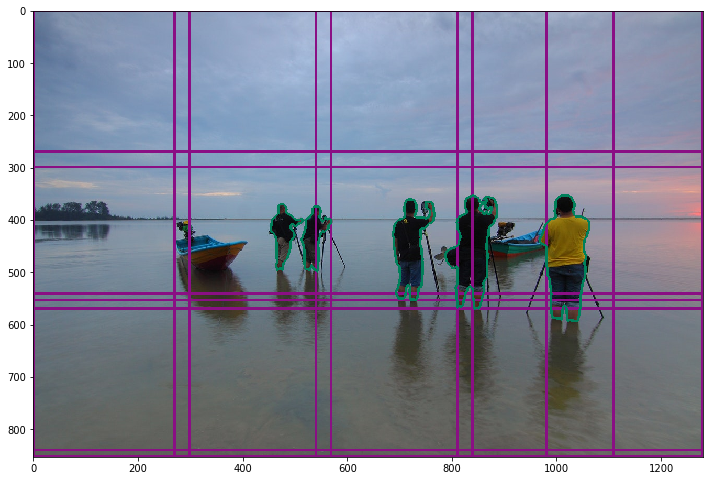

In [55]:
draw_image_with_labels(img, ann, figsize=(12, 12))

Compare the result with one for "full image" mode on the same image. Output for "sliding window" mode is obviously more clear.

Class person_dl | shape (853, 1280, 1) | type float64 | min=3.393035093342267e-13 | max=0.9999979436397552 | mean=0.03880664782262162 | std=0.18768143399422732


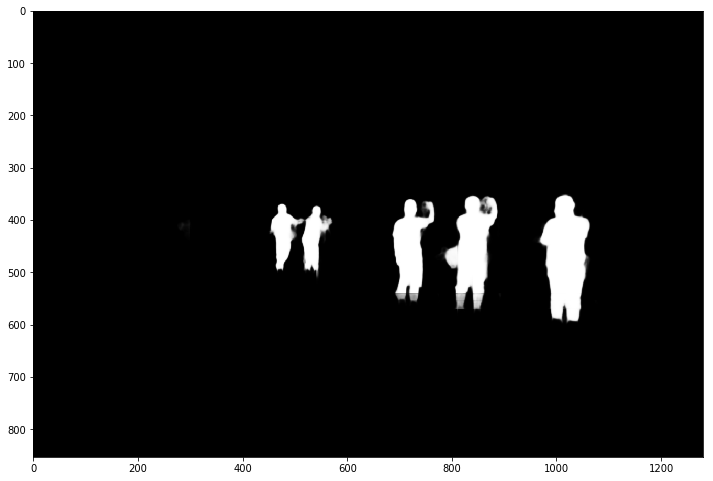

In [56]:
for lbl in ann.pixelwise_scores_labels:
    print_lbl_data(lbl)
    draw_confidences(lbl.geometry.data, figsize=(12, 12))

## Upload confidences to Supervisely server and download from server

The task doesn't require any additional work for NN confidences especially.

Save annotations as usual. Load annotations as usual, and pass flag `with_custom_data=True` to load pixelwise labels from server.

This is provided as an example of working code.

### Preparations

In [63]:
mode_config = {
    "model_classes": {
      "save_classes": ["bg", "dog", "person"],
      "add_suffix": "_dl"
    },
    "save_probabilities": True
}

CURR_PROJECT_ID = 26

In [64]:
src_project = api.project.get_info_by_id(CURR_PROJECT_ID)

src_project_meta_json = api.project.get_meta(src_project.id)
src_project_meta = sly.ProjectMeta.from_json(src_project_meta_json)

In [65]:
meta_json = api.model.get_output_meta(model.id, input_meta=src_project_meta_json, inference_mode=mode_config)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+------------------+-----------+-----------------+
|       Name       |   Shape   |      Color      |
+------------------+-----------+-----------------+
| some_interesting | Rectangle |  [253, 63, 145] |
|      bg_dl       |   Bitmap  | [182, 182, 159] |
|      dog_dl      |   Bitmap  |   [0, 81, 128]  |
|    person_dl     |   Bitmap  |   [0, 128, 90]  |
+------------------+-----------+-----------------+
Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



### Create target project

In [66]:
dst_project_name = DST_PROJECT_NAME
if api.project.exists(workspace.id, dst_project_name):
    dst_project_name = api.project.get_free_name(workspace.id, dst_project_name)
    
dst_project = api.project.create(workspace.id, dst_project_name, description="after inference")

api.project.update_meta(dst_project.id, model_meta.to_json())

print("Destination Project: id={}, name={!r}".format(dst_project.id, dst_project.name))

Destination Project: id=121, name='pixelwise_save_test_002'


### Run inference and upload results

In [67]:
results_ann = {}  # dst img_id -> ann

for dataset in api.dataset.get_list(src_project.id):
    print("Dataset: {!r}".format(dataset.name))
    dst_dataset = api.dataset.create(dst_project.id, dataset.name)
    
    for image in api.image.get_list(dataset.id):
        print('Image: {}'.format(image.name))
        dst_image = api.image.upload_id(dst_dataset.id, image.name, image.id)
        
        ann_json = api.model.inference_remote_image(model.id, dst_image.hash, mode=mode_config)
        print("\t\t...inference done...")
        
        ann = sly.Annotation.from_json(ann_json, model_meta)
        api.annotation.upload_json(dst_image.id, ann.to_json())
        results_ann[dst_image.id] = ann

print('Done.')

Dataset: 'ds1'
Image: fashion-model-girl-in-white-dress-hairstyle-hair-89785.jpeg
		...inference done...
Image: pexels-photo-164262.jpeg
		...inference done...
Image: img_01.jpeg
		...inference done...
Image: pexels-photo-675926.jpeg
		...inference done...
Image: img_02.jpeg
		...inference done...
Done.


### Download stored project and compare bitmaps with uploaded ones

And draw labels and confidence maps.

<span style="color:blue">**NOTE:**</span> pass `with_custom_data=True` flag through `api.annotation.download` to load pixelwise confidence labels from server.

Dataset: 'ds1'
Image: fashion-model-girl-in-white-dress-hairstyle-hair-89785.jpeg
		...anns downloaded...


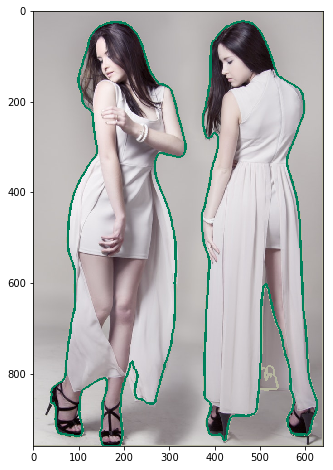

Class bg_dl | shape (960, 640, 1) | type float32 | min=3.268672230660741e-07 | max=1.0 | mean=0.4640297591686249 | std=0.4796745181083679


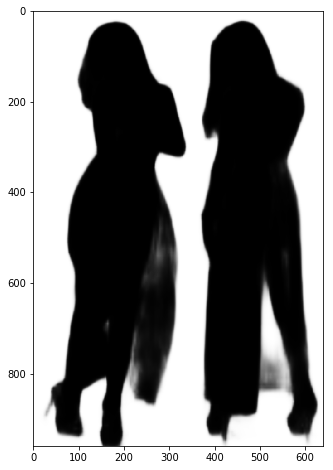

Class dog_dl | shape (960, 640, 1) | type float32 | min=1.0949678663774165e-11 | max=0.0004921274376101792 | mean=1.1210157708774204e-06 | std=1.0681222192943096e-05


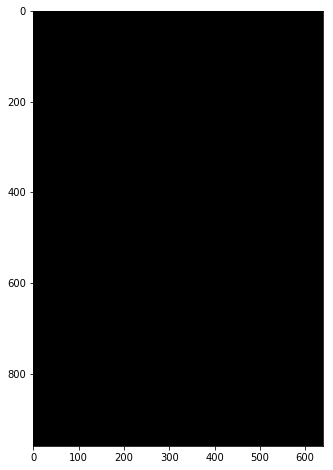

Class person_dl | shape (960, 640, 1) | type float32 | min=2.485722461198492e-10 | max=0.9999995231628418 | mean=0.5324563384056091 | std=0.48138442635536194


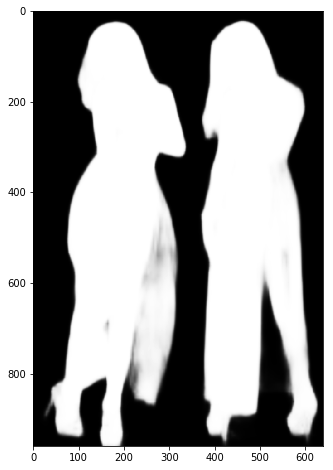







Image: pexels-photo-164262.jpeg
		...anns downloaded...


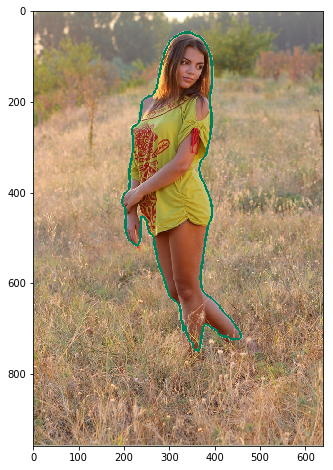

Class bg_dl | shape (959, 640, 1) | type float32 | min=2.7287846933177207e-06 | max=1.0 | mean=0.8572613596916199 | std=0.34189024567604065


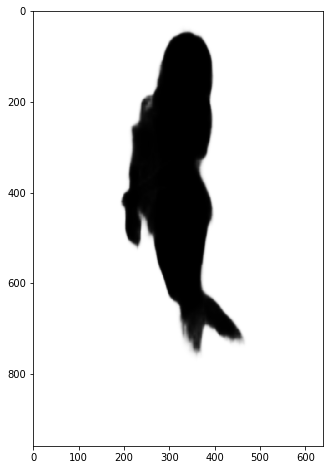

Class dog_dl | shape (959, 640, 1) | type float32 | min=1.4789041519192025e-11 | max=0.0033296674955636263 | mean=6.8518761509039905e-06 | std=5.2808976761298254e-05


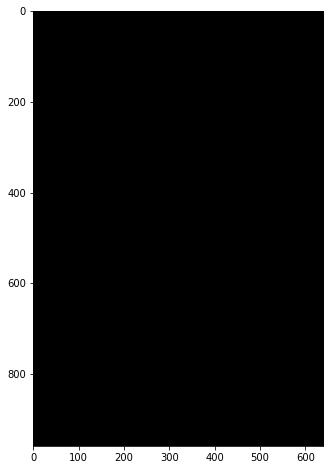

Class person_dl | shape (959, 640, 1) | type float32 | min=3.207719506681528e-11 | max=0.9999972581863403 | mean=0.14258839190006256 | std=0.34164929389953613


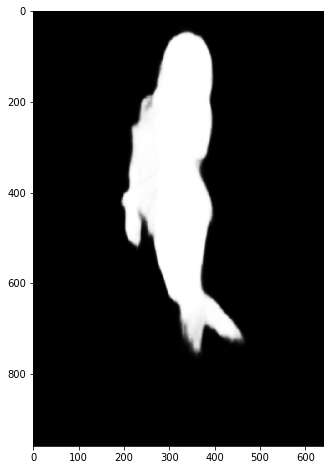







Image: img_01.jpeg
		...anns downloaded...


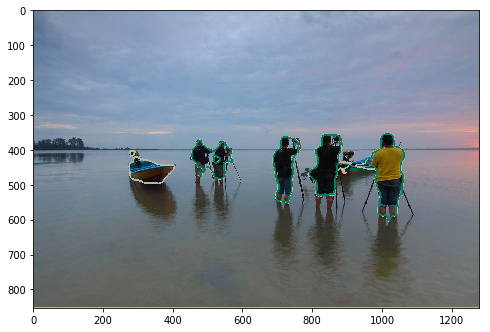

Class bg_dl | shape (853, 1280, 1) | type float32 | min=0.0005124874296598136 | max=1.0 | mean=0.9544352889060974 | std=0.1903229057788849


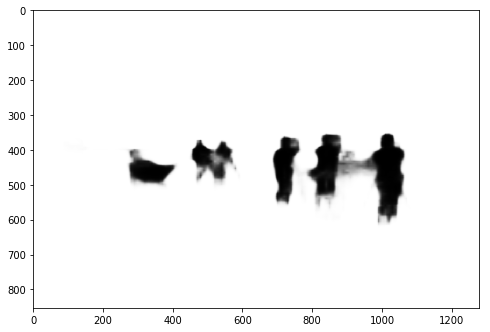

Class dog_dl | shape (853, 1280, 1) | type float32 | min=2.2015089404248123e-12 | max=0.002774784341454506 | mean=9.623613550502341e-06 | std=8.462681580567732e-05


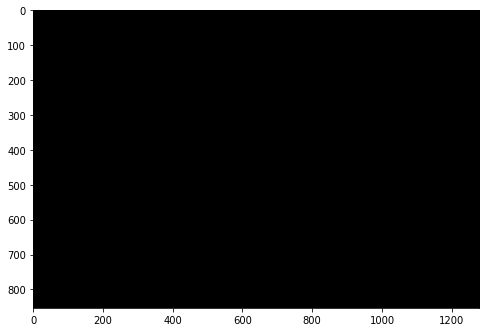

Class person_dl | shape (853, 1280, 1) | type float32 | min=1.0708383485491524e-10 | max=0.9994826316833496 | mean=0.03726476803421974 | std=0.17462515830993652


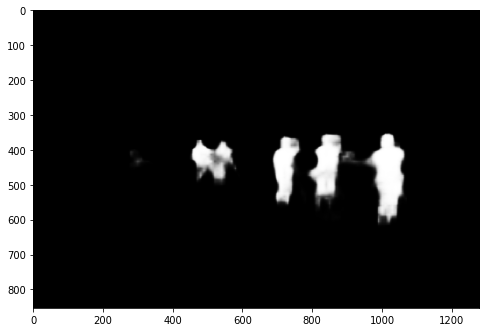







Image: pexels-photo-675926.jpeg
		...anns downloaded...


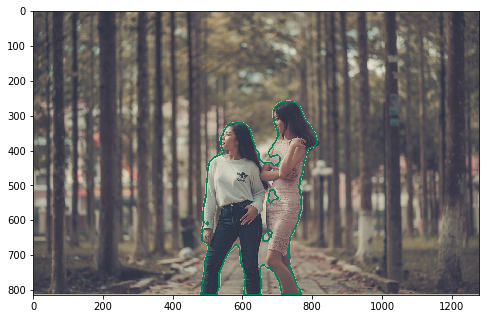

Class bg_dl | shape (814, 1280, 1) | type float32 | min=7.774048754072282e-06 | max=1.0 | mean=0.8920107483863831 | std=0.29737645387649536


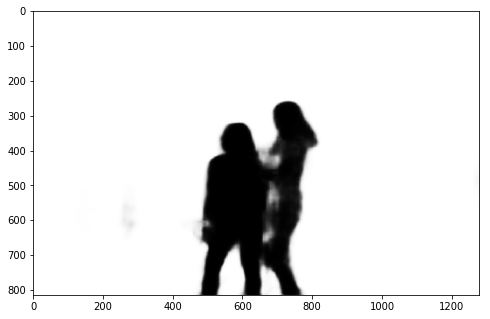

Class dog_dl | shape (814, 1280, 1) | type float32 | min=1.0426400194607499e-11 | max=0.0006182263605296612 | mean=1.4189954526955262e-06 | std=1.3390182175498921e-05


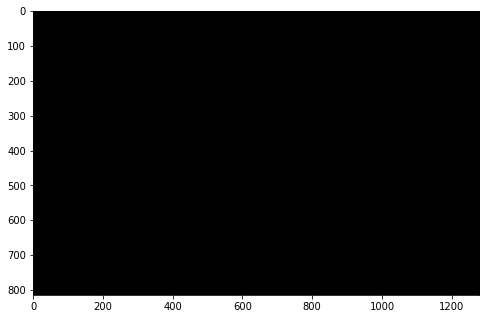

Class person_dl | shape (814, 1280, 1) | type float32 | min=5.8680177383863e-10 | max=0.9999921321868896 | mean=0.10757418721914291 | std=0.2973869740962982


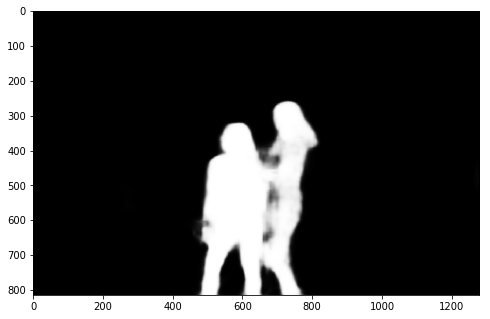







Image: img_02.jpeg
		...anns downloaded...


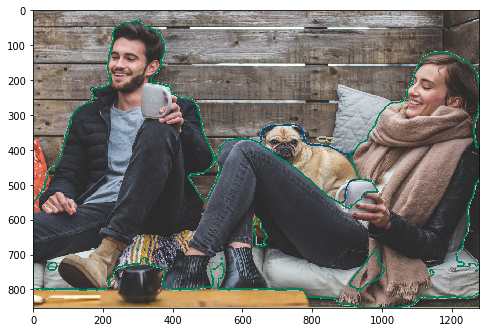

Class bg_dl | shape (853, 1280, 1) | type float32 | min=3.037026772290119e-07 | max=0.9999988079071045 | mean=0.41116562485694885 | std=0.45502713322639465


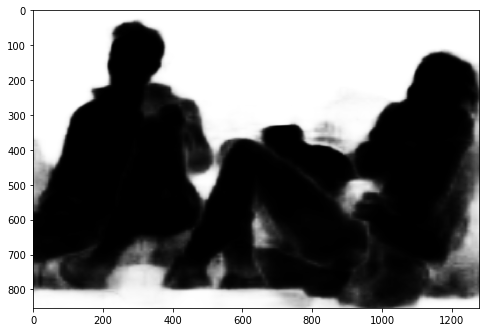

Class dog_dl | shape (853, 1280, 1) | type float32 | min=4.61651783467687e-09 | max=0.9999387264251709 | mean=0.033752910792827606 | std=0.16223198175430298


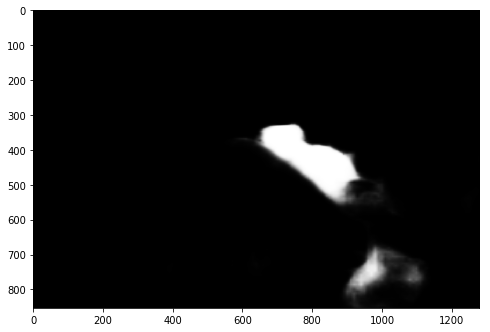

Class person_dl | shape (853, 1280, 1) | type float32 | min=5.272762138019971e-08 | max=0.9999997615814209 | mean=0.5497634410858154 | std=0.46134722232818604


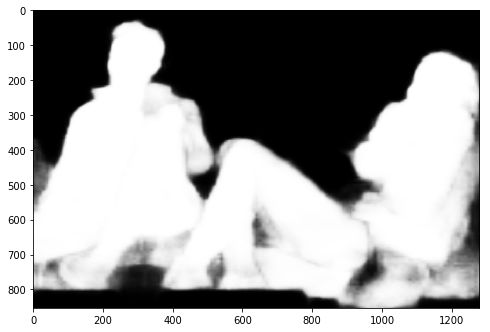

In [68]:
# order by class title, ok for now
def order_it(pixelwise_labels):
    return sorted(list(pixelwise_labels), key=lambda lbl: lbl.obj_class.name)


dup_project = api.project.get_info_by_id(dst_project.id)

dup_project_meta_json = api.project.get_meta(dup_project.id)
dup_project_meta = sly.ProjectMeta.from_json(dup_project_meta_json)

for dataset in api.dataset.get_list(dup_project.id):
    print("Dataset: {!r}".format(dataset.name))
    
    for image in api.image.get_list(dataset.id):
        print("Image: {}".format(image.name))
        dup_ann_info = api.annotation.download(image.id, with_custom_data=True)
        dup_ann_json = dup_ann_info.annotation
        dup_ann = sly.Annotation.from_json(dup_ann_json, dup_project_meta)
        
        ann = results_ann[image.id]
        print("\t\t...anns downloaded...")
        
        scores = order_it(ann.pixelwise_scores_labels)            
        dup_scores = order_it(dup_ann.pixelwise_scores_labels)
        assert(len(scores) == len(dup_scores))
        
        for lbl, dup_lbl in zip(scores, dup_scores):
            assert((lbl.geometry.data == dup_lbl.geometry.data).all())

        img = api.image.download_np(image.id)
        draw_image_with_labels(img, ann)
        
        for lbl in scores:
            print_lbl_data(lbl)
            draw_confidences(lbl.geometry.data) 
        print("\n" * 5)

### Check the same work with other API method

<span style="color:blue">**NOTE:**</span> here we pass `with_custom_data=True` flag through `api.annotation.download_batch` to load pixelwise labels from server.

In [69]:
for dataset in api.dataset.get_list(dup_project.id):
    print("Dataset: {!r}".format(dataset.name))
    
    img_infos = list(api.image.get_list(dataset.id))
    img_ids = [x.id for x in img_infos]
    print(img_ids)
    dup_anns_info = api.annotation.download_batch(dataset.id, img_ids, with_custom_data=True)
    
    for dup_ann_info, image in zip(dup_anns_info, img_infos):
        print("Image: {}".format(image.name))
        dup_ann_json = dup_ann_info.annotation
        dup_ann = sly.Annotation.from_json(dup_ann_json, dup_project_meta)
        
        ann = results_ann[image.id]
        print("\t\t...anns downloaded...")
        
        scores = order_it(ann.pixelwise_scores_labels)            
        dup_scores = order_it(dup_ann.pixelwise_scores_labels)
        assert(len(scores) == len(dup_scores))
        
        for lbl, dup_lbl in zip(scores, dup_scores):
            assert((lbl.geometry.data == dup_lbl.geometry.data).all())
        print("\t\t...compared.")

Dataset: 'ds1'
[1898, 1899, 1900, 1901, 1902]
Image: fashion-model-girl-in-white-dress-hairstyle-hair-89785.jpeg
		...anns downloaded...
		...compared.
Image: pexels-photo-164262.jpeg
		...anns downloaded...
		...compared.
Image: img_01.jpeg
		...anns downloaded...
		...compared.
Image: pexels-photo-675926.jpeg
		...anns downloaded...
		...compared.
Image: img_02.jpeg
		...anns downloaded...
		...compared.


## Clean up: undeploy model

In [ ]:
api.task.get_status(task_id)

In [ ]:
api.task.stop(task_id)
api.task.wait(task_id, api.task.Status.STOPPED)
print('task {} has been successfully stopped'.format(task_id))
print(api.task.get_status(task_id))